# Demo of the GTM on 10-Dimensional R-Vine-Copula Data

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 10 dimensional R-Vine-Copula as done in our [Paper](https://arxiv.org/pdf/2503.17845) Section 4.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv
# Helpers to generate specfific vines and analyze there conditional independencies
from pyvinecopulib_simulation_helpers import *

# Other Stuff
import numpy as np
import torch
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
from sklearn.metrics import roc_auc_score, roc_curve

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_seeds(1)

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a R-Vine-Copula and add Gaussian marginals. To create the Vine we use the functions `sample_random_pair_copulas`and `compute_conditional_dependence_table` from our helpers. Theses allow use to set independence copulas upon Tree 3 to add full conditional independencies as detailed in our Paper. The `df`contains a tables with the copulas, there parameters and there tree positions in a manner comparable to the conditional independence table later generated with the GTM.

In [3]:
D = 8  # dimension
rvine_structure = pv.RVineStructure.simulate(D)
pair_copulas = sample_random_pair_copulas(D,Independence_tree=3)
vine_model = pv.Vinecop.from_structure(structure=rvine_structure, pair_copulas=pair_copulas)
df = compute_conditional_dependence_table(vine_model)
#df

creating a table to compare the true dependence structure later on to what the gtm learned

In [4]:

df_true_structure = df[["tree","edge","conditioned variables", "conditioned variable 1", "conditioned variable 2", "dependence", "var_row", "var_col"]]
df_true_structure_sub = df_true_structure[["var_row", "var_col", "dependence"]]
df_true_structure_sub.loc[:, "var_row"] = df_true_structure_sub["var_row"] - 1
df_true_structure_sub.loc[:, "var_col"] = df_true_structure_sub["var_col"] - 1

The `pyvinecopulib`package offers to plot the tree structures:

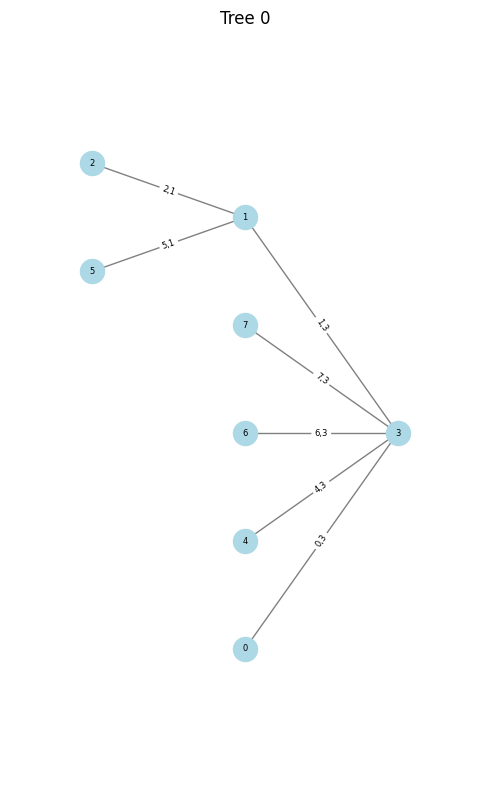

In [5]:
vine_model.plot(tree=[0])

In [6]:
# Train
N_train = 2000
simulated_data_uniform_train = vine_model.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = vine_model.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = vine_model.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [7]:
loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_train).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_validate).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_test).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [8]:
copula_pv_est = vine_model
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [9]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [10]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [11]:
model_freq = GTM(
        number_variables = D,
        number_transformation_layers = 1,
        number_decorrelation_layers= 3,
        degree_transformations = 15,
        degree_decorrelation = 30,
        spline_transformation = "bspline",
        spline_decorrelation = "bspline",
        transformation_spline_range = (-10, 10),
        device = "cuda" if torch.cuda.is_available() else "cpu")

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [12]:
#model_freq.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [13]:
#model_freq.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

#### 3.1 GTM

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [14]:
study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2026-01-04 13:53:24,610] A new study created in RDB with name: no-name-67ace2fb-5426-440d-82b3-fa0b7d63204a
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:620: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 5/2000 [00:00<02:06, 15.75it/s]

current_loss: tensor(1.4381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4223967790603638
current_loss: tensor(1.4373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4133232831954956
current_loss: tensor(1.4291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.404447317123413
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.404681921005249
current_loss: tensor(1.4225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.404184103012085


  0%|          | 9/2000 [00:00<01:30, 21.95it/s]

current_loss: tensor(1.4223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4041274785995483
current_loss: tensor(1.4223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4041004180908203
current_loss: tensor(1.4223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4040815830230713
current_loss: tensor(1.4222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4044294357299805
current_loss: tensor(1.4220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.404526948928833
current_loss: tensor(1.4220, d

  1%|          | 12/2000 [00:00<01:47, 18.56it/s]


current_loss: tensor(1.4218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4041513204574585
current_loss: tensor(1.4218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4041584730148315
Early Stop at iteration 12 with minimal loss tensor(1.4041, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<06:00,  5.54it/s]

current_loss: tensor(1.4136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.319602608680725
current_loss: tensor(1.3339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.197024941444397
current_loss: tensor(1.2152, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:17, 10.13it/s]

current_loss: tensor(1.1825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1668355464935303


  0%|          | 5/2000 [00:00<02:46, 11.99it/s]

current_loss: tensor(1.1825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1241086721420288
current_loss: tensor(1.1395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.119705080986023
current_loss: tensor(1.1352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1255, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:48, 11.79it/s]

current_loss_val:  1.1100887060165405
current_loss: tensor(1.1255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0874277353286743
current_loss: tensor(1.1021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.07370924949646


  0%|          | 9/2000 [00:00<02:49, 11.72it/s]

current_loss: tensor(1.0879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0654172897338867
current_loss: tensor(1.0795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0369694232940674
current_loss: tensor(1.0528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0476, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:39, 12.48it/s]

current_loss_val:  1.0318094491958618
current_loss: tensor(1.0476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0282260179519653
current_loss: tensor(1.0446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.020114779472351
current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0311, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:33, 12.94it/s]

current_loss_val:  1.014453411102295
current_loss: tensor(1.0311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0086119174957275
current_loss: tensor(1.0252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0061358213424683
current_loss: tensor(1.0215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0159, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:24, 13.69it/s]

current_loss_val:  1.002553939819336
current_loss: tensor(1.0159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.999488353729248
current_loss: tensor(1.0126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9970254302024841
current_loss: tensor(1.0094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0058, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:22, 13.85it/s]

current_loss_val:  0.9936900734901428
current_loss: tensor(1.0058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9853196740150452
current_loss: tensor(0.9993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9825170040130615
current_loss: tensor(0.9965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9939, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:01<02:19, 14.16it/s]

current_loss_val:  0.980405330657959
current_loss: tensor(0.9939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9756239652633667
current_loss: tensor(0.9896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9757876396179199
current_loss: tensor(0.9884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9862, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:19, 14.17it/s]

current_loss_val:  0.9730774164199829
current_loss: tensor(0.9862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9709891080856323
current_loss: tensor(0.9847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9697821736335754
current_loss: tensor(0.9834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9861, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:26, 13.48it/s]

current_loss: tensor(0.9812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.969027578830719
current_loss: tensor(0.9812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9679340124130249
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<02:24, 13.58it/s]

current_loss_val:  0.9673935770988464
current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:22, 13.78it/s]

current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.968044102191925
current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9665042161941528
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9656675457954407
current_loss: tensor(0.9735, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:21, 13.84it/s]

current_loss: tensor(0.9680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9594600200653076
current_loss: tensor(0.9680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9589181542396545
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:03<02:28, 13.18it/s]

current_loss_val:  0.95721036195755
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9553411602973938
current_loss: tensor(0.9630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9551938772201538
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:24, 13.53it/s]

current_loss_val:  0.9541102051734924
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9532906413078308
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9525209665298462
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:19, 14.01it/s]

current_loss_val:  0.9518698453903198
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.950439989566803
current_loss: tensor(0.9575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9501522779464722
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:03<02:18, 14.15it/s]

current_loss_val:  0.9503923654556274
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9499772787094116
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9495767951011658
current_loss: tensor(0.9554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:03<02:17, 14.24it/s]

current_loss_val:  0.9493572115898132
current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9488146901130676
current_loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:03<02:27, 13.18it/s]

current_loss: tensor(0.9546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9482870101928711
current_loss: tensor(0.9546, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:04<02:24, 13.48it/s]

current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.948115885257721
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478839635848999
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9482281804084778
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:04<02:21, 13.72it/s]

current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477856159210205
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947509765625
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:04<02:19, 13.89it/s]

current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474679231643677
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:04<02:20, 13.77it/s]

current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947484016418457
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9471079707145691
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9463245272636414


  3%|▎         | 61/2000 [00:04<02:28, 13.07it/s]

current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9461024403572083
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9444484114646912
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:04<02:32, 12.73it/s]

current_loss_val:  0.9427745342254639
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9421879053115845
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:04<02:26, 13.18it/s]

current_loss_val:  0.9404445290565491
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:05<02:30, 12.84it/s]

current_loss: tensor(0.9436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9404228329658508
current_loss: tensor(0.9436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395984411239624
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340928196907043
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:05<02:26, 13.22it/s]

current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9336674809455872
current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9325048327445984
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:05<02:23, 13.45it/s]

current_loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9321873188018799
current_loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:05<02:20, 13.67it/s]

current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931938886642456
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313254356384277
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314498901367188


  4%|▍         | 75/2000 [00:05<02:26, 13.17it/s]

current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9311487078666687
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9304327964782715


  4%|▍         | 77/2000 [00:05<02:22, 13.47it/s]

current_loss: tensor(0.9325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296681880950928


  4%|▍         | 79/2000 [00:05<02:19, 13.76it/s]

current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9289091229438782
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9290244579315186
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291923642158508


  4%|▍         | 81/2000 [00:06<02:18, 13.88it/s]

current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9292625188827515
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9290968179702759


  4%|▍         | 82/2000 [00:06<02:25, 13.14it/s]

current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9292753338813782
Early Stop at iteration 82 with minimal loss tensor(0.9289, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-04 13:53:33,684] Trial 0 finished with value: -7.431272506713867 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.304978802267217, 'penalty_decorrelation_ridge_second_difference': 2.467605522834725}. Best is trial 0 with value: -7.431272506713867.
  0%|          | 2/2000 [00:00<02:22, 14.02it/s]

current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313329458236694
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301212430000305
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9293406009674072


  0%|          | 4/2000 [00:00<02:20, 14.16it/s]

current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302005171775818
current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303817749023438
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:46, 11.95it/s]

current_loss_val:  0.9301683902740479
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9306325316429138
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9306224584579468
Early Stop at iteration 7 with minimal loss tensor(0.9293, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-04 13:53:35,108] Trial 1 finished with value: -7.4347243309021 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6208217276114645, 'penalty_decorrelation_ridge_second_difference': 28.155510329714208}. Best is trial 0 with value: -7.431272506713867.
  0%|          | 2/2000 [00:00<02:21, 14.07it/s]

current_loss: tensor(1.0166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9316272139549255
current_loss: tensor(1.0155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9300343990325928
current_loss: tensor(1.0137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.928978681564331


  0%|          | 4/2000 [00:00<03:36,  9.24it/s]

current_loss: tensor(1.0111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929366409778595
current_loss: tensor(1.0081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9382439255714417
current_loss: tensor(0.9941, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:17, 10.10it/s]

current_loss: tensor(0.9930, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9373791217803955
current_loss: tensor(0.9930, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353237748146057
current_loss: tensor(0.9900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349461793899536
Early Stop at iteration 7 with minimal loss tensor(0.9290, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-04 13:53:37,244] Trial 2 finished with value: -7.43182897567749 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.1755857422623, 'penalty_decorrelation_ridge_second_difference': 13.614886263903445}. Best is trial 0 with value: -7.431272506713867.
  0%|          | 2/2000 [00:00<02:25, 13.71it/s]

current_loss: tensor(1.0075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310673475265503
current_loss: tensor(1.0056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303865432739258


  0%|          | 4/2000 [00:00<05:09,  6.45it/s]

current_loss: tensor(1.0034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9321610331535339
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399687051773071
current_loss: tensor(0.9889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9838, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<06:56,  4.79it/s]

current_loss_val:  0.9329949021339417
current_loss: tensor(0.9838, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<07:01,  4.73it/s]

current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9321578741073608
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9312956929206848
Early Stop at iteration 6 with minimal loss tensor(0.9304, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-04 13:53:39,702] Trial 3 finished with value: -7.443091869354248 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.10131439368335, 'penalty_decorrelation_ridge_second_difference': 22.918528450684075}. Best is trial 0 with value: -7.431272506713867.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<08:12,  4.06it/s]

current_loss_val:  0.929279088973999
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9292308688163757
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296808838844299
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:32,  9.38it/s]

current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301807284355164
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295555949211121
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9294556379318237
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<05:03,  6.56it/s]


current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295285940170288
Early Stop at iteration 6 with minimal loss tensor(0.9292, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-04 13:53:41,346] Trial 4 finished with value: -7.433845520019531 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.458325661125527, 'penalty_decorrelation_ridge_second_difference': 11.512229961966614}. Best is trial 0 with value: -7.431272506713867.
  0%|          | 3/2000 [00:00<02:43, 12.20it/s]

current_loss: tensor(1.0040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9321394562721252
current_loss: tensor(1.0036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298069477081299
current_loss: tensor(1.0018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9289830327033997


  0%|          | 5/2000 [00:00<02:30, 13.23it/s]

current_loss: tensor(1.0009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288514256477356
current_loss: tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.930019199848175
current_loss: tensor(0.9929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9858, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:37, 12.63it/s]

current_loss_val:  0.934004545211792
current_loss: tensor(0.9858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9337273836135864
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9341862201690674
current_loss: tensor(0.9812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:54, 11.41it/s]


current_loss_val:  0.9365846514701843
Early Stop at iteration 8 with minimal loss tensor(0.9289, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-04 13:53:42,589] Trial 5 finished with value: -7.430810928344727 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.790358659388104, 'penalty_decorrelation_ridge_second_difference': 13.060664740325732}. Best is trial 5 with value: -7.430810928344727.
  0%|          | 2/2000 [00:00<02:30, 13.26it/s]

current_loss: tensor(0.9946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309083819389343
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9304925799369812
current_loss: tensor(0.9900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9336367249488831


  0%|          | 4/2000 [00:00<02:42, 12.31it/s]

current_loss: tensor(0.9752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9316703081130981
current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310346841812134
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:59, 11.14it/s]

current_loss_val:  0.9306039214134216
current_loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310676455497742
Early Stop at iteration 6 with minimal loss tensor(0.9305, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-04 13:53:43,710] Trial 6 finished with value: -7.443940162658691 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.503922192955052, 'penalty_decorrelation_ridge_second_difference': 28.36283229921057}. Best is trial 5 with value: -7.430810928344727.
  0%|          | 2/2000 [00:00<02:30, 13.29it/s]

current_loss: tensor(1.0246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303730726242065
current_loss: tensor(1.0215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313533902168274
current_loss: tensor(1.0170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0018, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:38, 12.60it/s]

current_loss_val:  0.9327212572097778
current_loss: tensor(1.0018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9333867430686951
current_loss: tensor(0.9957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9328387975692749
current_loss: tensor(0.9940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:02, 10.96it/s]


current_loss_val:  0.9344301223754883
Early Stop at iteration 5 with minimal loss tensor(0.9304, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-04 13:53:44,775] Trial 7 finished with value: -7.442984104156494 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.455164475814758, 'penalty_decorrelation_ridge_second_difference': 29.890512981297555}. Best is trial 5 with value: -7.430810928344727.
  0%|          | 2/2000 [00:00<03:06, 10.70it/s]

current_loss: tensor(0.9916, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9910, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9294160604476929
current_loss: tensor(0.9910, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302930235862732
current_loss: tensor(0.9884, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:38, 12.63it/s]

current_loss: tensor(0.9850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314826130867004
current_loss: tensor(0.9850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9335866570472717
current_loss: tensor(0.9792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344758987426758


  0%|          | 5/2000 [00:00<03:14, 10.27it/s]


current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352365732192993
Early Stop at iteration 5 with minimal loss tensor(0.9294, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-04 13:53:45,958] Trial 8 finished with value: -7.435328960418701 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.75784831595969, 'penalty_decorrelation_ridge_second_difference': 1.8025591533038117}. Best is trial 5 with value: -7.430810928344727.
  0%|          | 2/2000 [00:00<03:10, 10.50it/s]

current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295426607131958
current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9306060075759888
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:41, 12.38it/s]

current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931443989276886
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9308748245239258
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309703707695007
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:08, 10.57it/s]


current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9307319521903992
Early Stop at iteration 5 with minimal loss tensor(0.9295, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-04 13:53:47,714] Trial 9 finished with value: -7.436340808868408 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.1556226344537235, 'penalty_decorrelation_ridge_second_difference': 16.311332595827704}. Best is trial 5 with value: -7.430810928344727.
  0%|          | 2/2000 [00:00<02:44, 12.11it/s]

current_loss: tensor(1.0165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9308335781097412
current_loss: tensor(1.0142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346544742584229
current_loss: tensor(0.9990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350617527961731
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9893, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:49,  6.90it/s]

current_loss_val:  0.9323925971984863
current_loss: tensor(0.9893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9321668148040771
current_loss: tensor(0.9863, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:07,  6.49it/s]


current_loss: tensor(0.9838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313127994537354
Early Stop at iteration 5 with minimal loss tensor(0.9308, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-04 13:53:49,711] Trial 10 finished with value: -7.4466681480407715 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.254333168049744, 'penalty_decorrelation_ridge_second_difference': 23.70267069594672}. Best is trial 5 with value: -7.430810928344727.
  0%|          | 2/2000 [00:00<02:42, 12.32it/s]

current_loss: tensor(1.0144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931326687335968
current_loss: tensor(1.0129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302108883857727
current_loss: tensor(1.0109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0041, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:29, 13.37it/s]

current_loss_val:  0.9297980070114136
current_loss: tensor(1.0041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9316473603248596
current_loss: tensor(0.9968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317672848701477
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:06, 10.70it/s]

current_loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314343929290771
current_loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9334909319877625
current_loss: tensor(0.9883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9322458505630493
Early Stop at iteration 7 with minimal loss tensor(0.9298, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-04 13:53:51,100] Trial 11 finished with value: -7.43838357925415 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.696121770664078, 'penalty_decorrelation_ridge_second_difference': 17.76122659601555}. Best is trial 5 with value: -7.430810928344727.
  0%|          | 1/2000 [00:00<04:48,  6.93it/s]

current_loss: tensor(0.9960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9316242337226868
current_loss: tensor(0.9949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9300044178962708


  0%|          | 4/2000 [00:00<03:46,  8.80it/s]

current_loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9289405941963196
current_loss: tensor(0.9907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9292236566543579


  0%|          | 6/2000 [00:00<03:35,  9.26it/s]

current_loss: tensor(0.9880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9382263422012329
current_loss: tensor(0.9800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9338059425354004


  0%|          | 7/2000 [00:00<03:55,  8.45it/s]


current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9331721067428589
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9330480098724365
Early Stop at iteration 7 with minimal loss tensor(0.9289, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-04 13:53:52,685] Trial 12 finished with value: -7.431524276733398 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.634642749786128, 'penalty_decorrelation_ridge_second_difference': 20.02745383817571}. Best is trial 5 with value: -7.430810928344727.
  0%|          | 2/2000 [00:00<02:26, 13.68it/s]

current_loss: tensor(0.9740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9320115447044373
current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298143982887268
current_loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9289312958717346


  0%|          | 4/2000 [00:00<02:21, 14.07it/s]

current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288250803947449
current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298083186149597
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:30, 13.24it/s]

current_loss_val:  0.9307794570922852
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9306125640869141
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303977489471436
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9559, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:47, 11.93it/s]


current_loss_val:  0.9328678250312805
Early Stop at iteration 8 with minimal loss tensor(0.9288, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-04 13:53:53,975] Trial 13 finished with value: -7.430599689483643 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.290175948200676, 'penalty_decorrelation_ridge_second_difference': 22.56864994074887}. Best is trial 13 with value: -7.430599689483643.
  0%|          | 1/2000 [00:00<03:38,  9.16it/s]

current_loss: tensor(1.0326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305818676948547
current_loss: tensor(1.0299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310367703437805
current_loss: tensor(1.0263, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:27,  9.61it/s]

current_loss: tensor(1.0502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9326934218406677
current_loss: tensor(1.0123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.932543933391571
current_loss: tensor(1.0034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:33,  9.33it/s]

current_loss_val:  0.9335944056510925
current_loss: tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934168815612793
Early Stop at iteration 5 with minimal loss tensor(0.9306, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-04 13:53:55,182] Trial 14 finished with value: -7.444654941558838 and parameters: {'penalty_decorrelation_ridge_first_difference': 21.28132563940562, 'penalty_decorrelation_ridge_second_difference': 23.403438306467063}. Best is trial 13 with value: -7.430599689483643.
  0%|          | 2/2000 [00:00<03:10, 10.46it/s]

current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9294330477714539
current_loss: tensor(0.9800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303199648857117
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:39, 12.54it/s]

current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931349515914917
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9322134852409363
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9321534633636475


  0%|          | 5/2000 [00:00<03:22,  9.86it/s]


current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9323410987854004
Early Stop at iteration 5 with minimal loss tensor(0.9294, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-04 13:53:56,291] Trial 15 finished with value: -7.435463905334473 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.51753766516046, 'penalty_decorrelation_ridge_second_difference': 7.6003469756393915}. Best is trial 13 with value: -7.430599689483643.
  0%|          | 2/2000 [00:00<03:12, 10.37it/s]

current_loss: tensor(0.9729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9294564127922058
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303717613220215
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:06, 10.71it/s]

current_loss: tensor(0.9658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931278645992279
current_loss: tensor(0.9658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314587712287903
current_loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:39,  9.10it/s]


current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931120753288269
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9311179518699646
Early Stop at iteration 5 with minimal loss tensor(0.9295, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-04 13:53:57,466] Trial 16 finished with value: -7.435650825500488 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.637413769267685, 'penalty_decorrelation_ridge_second_difference': 11.31580340565736}. Best is trial 13 with value: -7.430599689483643.
  0%|          | 2/2000 [00:00<02:24, 13.80it/s]

current_loss: tensor(1.0472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305461645126343
current_loss: tensor(1.0445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9311639666557312
current_loss: tensor(1.0407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0225, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:35, 12.80it/s]

current_loss_val:  0.9346615672111511
current_loss: tensor(1.0225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355977773666382
current_loss: tensor(1.0128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354809522628784
current_loss: tensor(1.0104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0071, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:02, 10.91it/s]


current_loss_val:  0.9393529295921326
Early Stop at iteration 5 with minimal loss tensor(0.9305, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-04 13:53:58,535] Trial 17 finished with value: -7.444369316101074 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.309088706665037, 'penalty_decorrelation_ridge_second_difference': 19.561891795933324}. Best is trial 13 with value: -7.430599689483643.
  0%|          | 1/2000 [00:00<03:21,  9.90it/s]

current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296382069587708
current_loss: tensor(0.9626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9308781027793884
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:44, 12.09it/s]

current_loss: tensor(0.9539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931618332862854
current_loss: tensor(0.9539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9306818246841431
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302855730056763


  0%|          | 5/2000 [00:00<03:28,  9.58it/s]


current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9311670660972595
Early Stop at iteration 5 with minimal loss tensor(0.9296, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-04 13:53:59,699] Trial 18 finished with value: -7.437105655670166 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.2056292527876913, 'penalty_decorrelation_ridge_second_difference': 19.57588381979144}. Best is trial 13 with value: -7.430599689483643.
  0%|          | 2/2000 [00:00<02:47, 11.90it/s]

current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9292258024215698
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291852116584778
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:29, 13.31it/s]

current_loss_val:  0.9293729662895203
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9297799468040466
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295840263366699
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:56, 11.28it/s]

current_loss_val:  0.9296916127204895
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302557110786438
Early Stop at iteration 6 with minimal loss tensor(0.9292, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-04 13:54:00,839] Trial 19 finished with value: -7.4334821701049805 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.162405910923457, 'penalty_decorrelation_ridge_second_difference': 0.7219914280110551}. Best is trial 13 with value: -7.430599689483643.
  0%|          | 2/2000 [00:00<02:22, 13.99it/s]

current_loss: tensor(1.0216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9321417212486267
current_loss: tensor(1.0212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298143982887268
current_loss: tensor(1.0194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9289994835853577


  0%|          | 6/2000 [00:00<02:22, 14.00it/s]

current_loss: tensor(1.0185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288730621337891
current_loss: tensor(1.0173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303032755851746
current_loss: tensor(1.0101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.950542688369751


  0%|          | 8/2000 [00:00<02:23, 13.86it/s]

current_loss: tensor(1.0022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939724862575531
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386046528816223
current_loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:41, 12.30it/s]


current_loss_val:  0.9381632804870605
Early Stop at iteration 8 with minimal loss tensor(0.9289, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-04 13:54:02,084] Trial 20 finished with value: -7.4309844970703125 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.810118248074463, 'penalty_decorrelation_ridge_second_difference': 6.108474164005925}. Best is trial 13 with value: -7.430599689483643.
  0%|          | 2/2000 [00:00<02:24, 13.80it/s]

current_loss: tensor(1.0160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9320496320724487
current_loss: tensor(1.0154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929847240447998
current_loss: tensor(1.0137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9289663434028625


  0%|          | 4/2000 [00:00<02:23, 13.89it/s]

current_loss: tensor(1.0126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288790822029114
current_loss: tensor(1.0113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.930580735206604
current_loss: tensor(1.0029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:31, 13.18it/s]

current_loss_val:  0.9355676770210266
current_loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354890584945679
current_loss: tensor(0.9911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9363824725151062
current_loss: tensor(0.9887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9863, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:47, 11.87it/s]


current_loss_val:  0.9390186667442322
Early Stop at iteration 8 with minimal loss tensor(0.9289, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-04 13:54:03,329] Trial 21 finished with value: -7.431032180786133 and parameters: {'penalty_decorrelation_ridge_first_difference': 25.81711011523972, 'penalty_decorrelation_ridge_second_difference': 9.482292122586871}. Best is trial 13 with value: -7.430599689483643.
  0%|          | 2/2000 [00:00<02:24, 13.85it/s]

current_loss: tensor(1.0200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9319882392883301
current_loss: tensor(1.0194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929872453212738
current_loss: tensor(1.0176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9289535284042358


  0%|          | 4/2000 [00:00<02:21, 14.11it/s]

current_loss: tensor(1.0164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288999438285828
current_loss: tensor(1.0151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309964179992676
current_loss: tensor(1.0054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9974, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:32, 13.05it/s]

current_loss_val:  0.935772716999054
current_loss: tensor(0.9974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357345700263977
current_loss: tensor(0.9940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370614290237427
current_loss: tensor(0.9905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9880, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:49, 11.78it/s]


current_loss_val:  0.939165472984314
Early Stop at iteration 8 with minimal loss tensor(0.9289, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-04 13:54:04,635] Trial 22 finished with value: -7.431199073791504 and parameters: {'penalty_decorrelation_ridge_first_difference': 27.701912316142746, 'penalty_decorrelation_ridge_second_difference': 8.477382798019006}. Best is trial 13 with value: -7.430599689483643.
  0%|          | 2/2000 [00:00<03:09, 10.53it/s]

current_loss: tensor(1.0138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296495914459229
current_loss: tensor(1.0129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310811161994934
current_loss: tensor(1.0076, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:46, 12.00it/s]

current_loss: tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9343814849853516
current_loss: tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9382114410400391
current_loss: tensor(0.9904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9880, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:25,  9.73it/s]


current_loss_val:  0.9374915957450867
current_loss: tensor(0.9880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9373522996902466
Early Stop at iteration 5 with minimal loss tensor(0.9296, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-04 13:54:05,831] Trial 23 finished with value: -7.437196254730225 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.73300828695662, 'penalty_decorrelation_ridge_second_difference': 2.7793594027431237}. Best is trial 13 with value: -7.430599689483643.
  0%|          | 1/2000 [00:00<03:20,  9.98it/s]

current_loss: tensor(0.9974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929547131061554
current_loss: tensor(0.9966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9307110905647278
current_loss: tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<02:53, 11.50it/s]

current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.932761013507843
current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344548583030701
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:28,  9.58it/s]

current_loss_val:  0.9341368675231934
current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934233546257019
Early Stop at iteration 5 with minimal loss tensor(0.9295, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-04 13:54:07,088] Trial 24 finished with value: -7.436376571655273 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.558236322206124, 'penalty_decorrelation_ridge_second_difference': 6.082051796076278}. Best is trial 13 with value: -7.430599689483643.
  0%|          | 2/2000 [00:00<02:25, 13.71it/s]

current_loss: tensor(1.0350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9312272667884827
current_loss: tensor(1.0333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.930318295955658
current_loss: tensor(1.0313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310550093650818


  0%|          | 4/2000 [00:00<02:21, 14.14it/s]

current_loss: tensor(1.0204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355032444000244
current_loss: tensor(1.0096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352071285247803
current_loss: tensor(1.0042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0012, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:58, 11.14it/s]

current_loss_val:  0.933681070804596
current_loss: tensor(1.0012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933693528175354
Early Stop at iteration 6 with minimal loss tensor(0.9303, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-04 13:54:08,361] Trial 25 finished with value: -7.442546367645264 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.84339320222965, 'penalty_decorrelation_ridge_second_difference': 11.934071340833444}. Best is trial 13 with value: -7.430599689483643.
  0%|          | 2/2000 [00:00<03:10, 10.47it/s]

current_loss: tensor(0.9922, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9297038912773132
current_loss: tensor(0.9912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9311763048171997
current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:42, 12.29it/s]

current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9331056475639343
current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9325831532478333
current_loss: tensor(0.9748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9335443377494812
current_loss: tensor(0.9732, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:11, 10.42it/s]


current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9327574968338013
Early Stop at iteration 5 with minimal loss tensor(0.9297, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-04 13:54:09,518] Trial 26 finished with value: -7.4376301765441895 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.185352313321644, 'penalty_decorrelation_ridge_second_difference': 13.128899430311725}. Best is trial 13 with value: -7.430599689483643.
  0%|          | 2/2000 [00:00<02:24, 13.84it/s]

current_loss: tensor(1.0028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9322118163108826
current_loss: tensor(1.0024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9297822117805481
current_loss: tensor(1.0006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929003119468689


  0%|          | 4/2000 [00:00<02:43, 12.17it/s]

current_loss: tensor(0.9998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288454055786133
current_loss: tensor(0.9987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298251271247864
current_loss: tensor(0.9926, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:45, 12.02it/s]

current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9342212080955505
current_loss: tensor(0.9848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9339596629142761
current_loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:58, 11.13it/s]

current_loss_val:  0.9342243075370789
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392265677452087
Early Stop at iteration 8 with minimal loss tensor(0.9288, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-04 13:54:10,881] Trial 27 finished with value: -7.43076229095459 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.51705731232133, 'penalty_decorrelation_ridge_second_difference': 12.89806726192631}. Best is trial 13 with value: -7.430599689483643.
  0%|          | 2/2000 [00:00<02:22, 14.04it/s]

current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9319199323654175
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298508763313293
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9289084672927856


  0%|          | 4/2000 [00:00<02:20, 14.18it/s]

current_loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288473129272461
current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301843643188477
current_loss: tensor(0.9638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:31, 13.14it/s]

current_loss_val:  0.9307975769042969
current_loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305822253227234
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.930188775062561
current_loss: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9566, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:48, 11.85it/s]


current_loss_val:  0.9321715235710144
Early Stop at iteration 8 with minimal loss tensor(0.9288, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-04 13:54:12,248] Trial 28 finished with value: -7.430778503417969 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.207280714958672, 'penalty_decorrelation_ridge_second_difference': 22.530944237648406}. Best is trial 13 with value: -7.430599689483643.
  0%|          | 2/2000 [00:00<02:23, 13.95it/s]

current_loss: tensor(0.9920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313930869102478
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301212430000305
current_loss: tensor(0.9887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9292879104614258


  0%|          | 4/2000 [00:00<02:20, 14.20it/s]

current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301859140396118
current_loss: tensor(0.9790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310610890388489
current_loss: tensor(0.9763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:58, 11.17it/s]

current_loss_val:  0.930908203125
current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314196705818176
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317041635513306
Early Stop at iteration 7 with minimal loss tensor(0.9293, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-04 13:54:13,631] Trial 29 finished with value: -7.434302806854248 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.156153027526983, 'penalty_decorrelation_ridge_second_difference': 23.356473940753677}. Best is trial 13 with value: -7.430599689483643.


hyperparameter_tuning done


In [15]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4291, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<00:27, 35.97it/s]

current_loss: tensor(1.4291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4223, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<00:31, 31.72it/s]

current_loss: tensor(1.4223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4222, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:00<00:28, 34.27it/s]

current_loss: tensor(1.4220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4218, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  2%|▏         | 22/1000 [00:00<00:24, 39.87it/s]

tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor

  3%|▎         | 27/1000 [00:00<00:24, 39.48it/s]

current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 32/1000 [00:00<00:23, 41.27it/s]

current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:00<00:26, 36.65it/s]

current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  4%|▍         | 45/1000 [00:01<00:25, 37.48it/s]

current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  5%|▌         | 54/1000 [00:01<00:23, 40.29it/s]

current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  6%|▌         | 59/1000 [00:01<00:23, 39.92it/s]

current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 64/1000 [00:01<00:23, 40.68it/s]

current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 69/1000 [00:01<00:22, 40.86it/s]

current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  8%|▊         | 78/1000 [00:02<00:24, 37.17it/s]

current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  8%|▊         | 82/1000 [00:02<00:25, 36.23it/s]

current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 87/1000 [00:02<00:24, 37.72it/s]

current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 91/1000 [00:02<00:27, 32.54it/s]

current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 10%|▉         | 96/1000 [00:02<00:25, 35.03it/s]

current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 101/1000 [00:02<00:24, 37.08it/s]

current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 105/1000 [00:02<00:24, 37.23it/s]

current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 109/1000 [00:02<00:25, 34.50it/s]

current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 114/1000 [00:03<00:24, 35.95it/s]

current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 12%|█▏        | 122/1000 [00:03<00:24, 36.51it/s]

current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 13%|█▎        | 126/1000 [00:03<00:26, 32.40it/s]

current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 131/1000 [00:03<00:24, 36.01it/s]

current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 136/1000 [00:03<00:23, 36.97it/s]

current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 14%|█▍        | 141/1000 [00:03<00:22, 38.27it/s]

current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 150/1000 [00:04<00:29, 28.60it/s]

current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 16%|█▌        | 159/1000 [00:04<00:25, 33.48it/s]

current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 17%|█▋        | 169/1000 [00:04<00:22, 37.56it/s]

current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 17%|█▋        | 174/1000 [00:04<00:22, 36.01it/s]

tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor

 18%|█▊        | 183/1000 [00:05<00:21, 38.16it/s]

current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 19%|█▊        | 187/1000 [00:05<00:29, 27.75it/s]

current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 19%|█▉        | 189/1000 [00:05<00:24, 33.57it/s]

current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 189 with minimal loss tensor(1.4209, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [16]:
# train the joint model
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3705, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<01:47,  9.31it/s]

current_loss_val:  1.3553268909454346
current_loss: tensor(1.3705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1756577491760254
current_loss: tensor(1.1938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4827, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<01:27, 11.38it/s]

current_loss: tensor(1.1613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1441682577133179
current_loss: tensor(1.1613, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<01:17, 12.79it/s]

current_loss: tensor(1.1471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.130824327468872
current_loss: tensor(1.1471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1016323566436768
current_loss: tensor(1.1184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0905861854553223


  1%|          | 7/1000 [00:00<01:19, 12.54it/s]

current_loss: tensor(1.1083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0810390710830688
current_loss: tensor(1.0996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0556726455688477
current_loss: tensor(1.0828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0789, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<01:20, 12.32it/s]

current_loss_val:  1.0527087450027466
current_loss: tensor(1.0789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0496872663497925
current_loss: tensor(1.0747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0611, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:00<01:16, 13.00it/s]

current_loss_val:  1.0388399362564087
current_loss: tensor(1.0611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0470, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:01<01:13, 13.44it/s]

current_loss_val:  1.0205050706863403
current_loss: tensor(1.0470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.017369031906128
current_loss: tensor(1.0451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0108928680419922
current_loss: tensor(1.0384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0365, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:01<01:11, 13.72it/s]

current_loss_val:  1.0095597505569458
current_loss: tensor(1.0365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0081040859222412
current_loss: tensor(1.0330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0309, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:01<01:10, 14.01it/s]

current_loss_val:  1.0113017559051514
current_loss: tensor(1.0309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0263, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:01<01:09, 14.16it/s]

current_loss_val:  1.005629539489746
current_loss: tensor(1.0263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0046945810317993
current_loss: tensor(1.0255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0025601387023926
current_loss: tensor(1.0232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0188, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:01<01:08, 14.22it/s]

current_loss_val:  1.0005357265472412
current_loss: tensor(1.0188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9963018298149109
current_loss: tensor(1.0132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0017, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:01<01:08, 14.34it/s]

current_loss_val:  0.9873037338256836
current_loss: tensor(1.0017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0068, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:01<01:11, 13.69it/s]

current_loss: tensor(0.9959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9802818298339844
current_loss: tensor(0.9959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9798413515090942
current_loss: tensor(0.9946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9786928296089172
current_loss: tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:02<01:14, 13.04it/s]

current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9783286452293396
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9785001277923584


  3%|▎         | 29/1000 [00:02<01:13, 13.25it/s]

current_loss: tensor(0.9921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.977949321269989


  3%|▎         | 31/1000 [00:02<01:11, 13.56it/s]

current_loss: tensor(0.9914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9774573445320129
current_loss: tensor(0.9902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9758428335189819
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9755756258964539


  3%|▎         | 33/1000 [00:02<01:09, 13.82it/s]

current_loss: tensor(0.9889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754211902618408
current_loss: tensor(0.9885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9749236702919006
current_loss: tensor(0.9879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9877, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:02<01:12, 13.32it/s]

current_loss_val:  0.9743227958679199
current_loss: tensor(0.9877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9740659594535828
current_loss: tensor(0.9874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9863, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:02<01:10, 13.64it/s]

current_loss_val:  0.9730197787284851
current_loss: tensor(0.9863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9848, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:02<01:09, 13.78it/s]

current_loss_val:  0.9719493389129639
current_loss: tensor(0.9848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9707939028739929
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9673064947128296
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:03<01:08, 13.95it/s]

current_loss_val:  0.9645563364028931
current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.96014004945755
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9715, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 43/1000 [00:03<01:07, 14.13it/s]

current_loss_val:  0.9554696679115295
current_loss: tensor(0.9715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:03<01:10, 13.56it/s]

current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9540166258811951
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.952066957950592
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9492464661598206
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:03<01:12, 13.10it/s]

current_loss: tensor(1.0258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9484853744506836
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9466091990470886
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 49/1000 [00:03<01:14, 12.83it/s]

current_loss_val:  0.9470746517181396
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9467325806617737
current_loss: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 51/1000 [00:03<01:11, 13.32it/s]

current_loss_val:  0.9464476704597473
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9572, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 53/1000 [00:03<01:09, 13.65it/s]

current_loss_val:  0.9457544684410095
current_loss: tensor(0.9572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9454875588417053
current_loss: tensor(0.9568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9451264142990112
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:04<01:11, 13.20it/s]

current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9452091455459595
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9446479678153992
current_loss: tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 57/1000 [00:04<01:09, 13.56it/s]

current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9444264769554138
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 59/1000 [00:04<01:08, 13.79it/s]

current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9444479942321777
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9439986944198608
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9440145492553711
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:04<01:07, 13.97it/s]

current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9436250329017639
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9424677491188049
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 63/1000 [00:04<01:06, 14.09it/s]

current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9419047236442566
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 65/1000 [00:04<01:05, 14.17it/s]

current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409571886062622
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9401658177375793
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9388887286186218
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 67/1000 [00:04<01:05, 14.24it/s]

current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381963610649109
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9362432956695557
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 69/1000 [00:05<01:09, 13.47it/s]

current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935836911201477


  7%|▋         | 71/1000 [00:05<01:07, 13.79it/s]

current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349823594093323
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305996894836426
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 73/1000 [00:05<01:10, 13.20it/s]

current_loss_val:  0.9301921725273132
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301913380622864
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9304625391960144
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:05<01:08, 13.51it/s]

current_loss_val:  0.929510772228241
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9293063282966614
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 77/1000 [00:05<01:06, 13.82it/s]

current_loss_val:  0.9285011291503906
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 79/1000 [00:05<01:05, 13.99it/s]

current_loss_val:  0.9278342723846436
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9275423884391785
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270632863044739
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 81/1000 [00:05<01:05, 14.10it/s]

current_loss_val:  0.9271110892295837
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9272201657295227
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 83/1000 [00:06<01:04, 14.24it/s]

current_loss_val:  0.9272701740264893
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 85/1000 [00:06<01:04, 14.29it/s]

current_loss_val:  0.9271389245986938
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9267001748085022
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9264734983444214
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 87/1000 [00:06<01:07, 13.60it/s]

current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9258970022201538
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9258568286895752
current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 89/1000 [00:06<01:05, 13.85it/s]

current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9257186055183411
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 91/1000 [00:06<01:08, 13.23it/s]

current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9263224601745605
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9260614514350891
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9260339736938477


  9%|▉         | 93/1000 [00:06<01:07, 13.44it/s]

current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9260075092315674
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9257864952087402
Early Stop at iteration 93 with minimal loss tensor(0.9257, device='cuda:0') and patience 5 and min_delta 1e-07


#### 3.2 BGTM


In [17]:
# Create dataset and DataLoader
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [18]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}


model = GTM(
    number_variables=D,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=15,
    degree_decorrelation=30,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                mu_init=model_freq.state_dict(),
                optimizer="Adam",
                #lr_mu = 1e-3,
                #lr_cholesky = 1e-4,
                #lr_rho = 3e-4,
                #lr_tau = 1.5e-3,
                
                lr_mu       = 3e-4,
                lr_cholesky = 3e-5,
                lr_rho      = 1e-4,
                lr_tau      = 5e-4,
                
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=20,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=10, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.1,    # try 1.5–3.0
                beta_kl_anneal_epochs = 60,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.2,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 50,   # used if conv_use_ema=False
                conv_tol = 0.005, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 50,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'transformation.params.2', 'transformation.params.3', 'transformation.params.4', 'transformation.params.5', 'transformation.params.6', 'transformation.params.7', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 2824 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 2824])
sigma summary: 0.050011005252599716 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


  1%|          | 5/800 [01:19<3:25:47, 15.53s/it]

[convergence] ELBO/obs=-24.277052  smoothed=-18.587093  tol=0.005

Iteration [5/800] train=24.2771  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0532 σmin=0.0503 σmax=0.0563  β_KL=0.16
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.07614  τ₁≈2.2825  τ₂≈4.5453  |  (EB targets) τ₄*≈0.66181  τ₁*≈26.142  τ₂*≈32.639
E_qf_total≈164.3434  E_qf1≈8.8966  E_qf2≈7.0810
[monitor] τ₄·E_qf≈12.51  target≈108.76 | τ₁·E_qf1≈20.31  target≈232.57 | τ₂·E_qf2≈32.19  target≈231.12
 [ELBO] per-obs=-24.277052


  1%|▏         | 10/800 [02:34<3:19:19, 15.14s/it]

[convergence] ELBO/obs=-33.298501  smoothed=-23.292106  tol=0.005

Iteration [10/800] train=33.2985  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0552 σmin=0.0509 σmax=0.0604  β_KL=0.23
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.059912  τ₁≈1.7932  τ₂≈3.5519  |  (EB targets) τ₄*≈0.6664  τ₁*≈26.201  τ₂*≈32.354
E_qf_total≈163.0744  E_qf1≈8.8749  E_qf2≈7.1464
[monitor] τ₄·E_qf≈9.77  target≈108.67 | τ₁·E_qf1≈15.91  target≈232.53 | τ₂·E_qf2≈25.38  target≈231.22
 [ELBO] per-obs=-33.298501


  2%|▏         | 15/800 [03:49<3:17:02, 15.06s/it]

[convergence] ELBO/obs=-42.362831  smoothed=-29.779893  tol=0.005

Iteration [15/800] train=42.3628  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0561 σmin=0.0514 σmax=0.0613  β_KL=0.31
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.05138  τ₁≈1.5373  τ₂≈3.0413  |  (EB targets) τ₄*≈0.66977  τ₁*≈26.791  τ₂*≈33.475
E_qf_total≈162.1514  E_qf1≈8.6648  E_qf2≈6.8959
[monitor] τ₄·E_qf≈8.33  target≈108.60 | τ₁·E_qf1≈13.32  target≈232.14 | τ₂·E_qf2≈20.97  target≈230.84
 [ELBO] per-obs=-42.362831


  2%|▎         | 20/800 [05:04<3:13:56, 14.92s/it]

[convergence] ELBO/obs=-51.530525  smoothed=-37.352803  tol=0.005

Iteration [20/800] train=51.5305  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0565 σmin=0.0517 σmax=0.0617  β_KL=0.39
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.046136  τ₁≈1.3842  τ₂≈2.7412  |  (EB targets) τ₄*≈0.67223  τ₁*≈27.718  τ₂*≈35.375
E_qf_total≈161.4847  E_qf1≈8.3528  E_qf2≈6.5077
[monitor] τ₄·E_qf≈7.45  target≈108.56 | τ₁·E_qf1≈11.56  target≈231.52 | τ₂·E_qf2≈17.84  target≈230.21
 [ELBO] per-obs=-51.530525


  3%|▎         | 25/800 [06:19<3:14:38, 15.07s/it]

[convergence] ELBO/obs=-60.489725  smoothed=-45.518252  tol=0.005

Iteration [25/800] train=60.4897  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0569 σmin=0.0521 σmax=0.0641  β_KL=0.46
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.041939  τ₁≈1.2639  τ₂≈2.5101  |  (EB targets) τ₄*≈0.67526  τ₁*≈28.915  τ₂*≈38.107
E_qf_total≈160.6719  E_qf1≈7.9794  E_qf2≈6.0172
[monitor] τ₄·E_qf≈6.74  target≈108.49 | τ₁·E_qf1≈10.09  target≈230.72 | τ₂·E_qf2≈15.10  target≈229.30
 [ELBO] per-obs=-60.489725


  4%|▍         | 30/800 [07:34<3:11:12, 14.90s/it]

[convergence] ELBO/obs=-69.698938  smoothed=-54.076309  tol=0.005

Iteration [30/800] train=69.6989  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0572 σmin=0.0523 σmax=0.0685  β_KL=0.54
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.039747  τ₁≈1.2024  τ₂≈2.3935  |  (EB targets) τ₄*≈0.67677  τ₁*≈29.836  τ₂*≈40.241
E_qf_total≈160.2679  E_qf1≈7.7124  E_qf2≈5.6805
[monitor] τ₄·E_qf≈6.37  target≈108.46 | τ₁·E_qf1≈9.27  target≈230.11 | τ₂·E_qf2≈13.60  target≈228.59
 [ELBO] per-obs=-69.698938


  4%|▍         | 35/800 [08:48<3:09:45, 14.88s/it]

[convergence] ELBO/obs=-78.702586  smoothed=-62.843949  tol=0.005

Iteration [35/800] train=78.7026  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0577 σmin=0.0525 σmax=0.0735  β_KL=0.61
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.03763  τ₁≈1.143  τ₂≈2.2818  |  (EB targets) τ₄*≈0.67815  τ₁*≈30.381  τ₂*≈41.743
E_qf_total≈159.8999  E_qf1≈7.5620  E_qf2≈5.4640
[monitor] τ₄·E_qf≈6.02  target≈108.44 | τ₁·E_qf1≈8.64  target≈229.75 | τ₂·E_qf2≈12.47  target≈228.09
 [ELBO] per-obs=-78.702586


  5%|▌         | 40/800 [10:04<3:10:56, 15.07s/it]

[convergence] ELBO/obs=-87.819826  smoothed=-71.749869  tol=0.005

Iteration [40/800] train=87.8198  S_train=16 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0583 σmin=0.0528 σmax=0.0790  β_KL=0.69
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.036391  τ₁≈1.1082  τ₂≈2.2164  |  (EB targets) τ₄*≈0.67921  τ₁*≈30.803  τ₂*≈43.056
E_qf_total≈159.6191  E_qf1≈7.4493  E_qf2≈5.2872
[monitor] τ₄·E_qf≈5.81  target≈108.42 | τ₁·E_qf1≈8.26  target≈229.46 | τ₂·E_qf2≈11.72  target≈227.65
 [ELBO] per-obs=-87.819826


  6%|▌         | 45/800 [11:19<3:10:38, 15.15s/it]

[convergence] ELBO/obs=-96.839407  smoothed=-80.695885  tol=0.005

Iteration [45/800] train=96.8394  S_train=32 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0590 σmin=0.0530 σmax=0.0874  β_KL=0.76
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.035357  τ₁≈1.079  τ₂≈2.1619  |  (EB targets) τ₄*≈0.68029  τ₁*≈31.422  τ₂*≈44.841
E_qf_total≈159.3350  E_qf1≈7.2896  E_qf2≈5.0635
[monitor] τ₄·E_qf≈5.63  target≈108.39 | τ₁·E_qf1≈7.87  target≈229.05 | τ₂·E_qf2≈10.95  target≈227.05
 [ELBO] per-obs=-96.839407


  6%|▋         | 50/800 [12:34<3:07:46, 15.02s/it]

[convergence] ELBO/obs=-105.808304  smoothed=-89.643043  tol=0.005

Iteration [50/800] train=105.8083  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0598 σmin=0.0533 σmax=0.0968  β_KL=0.83
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.03441  τ₁≈1.0522  τ₂≈2.1121  |  (EB targets) τ₄*≈0.68126  τ₁*≈31.802  τ₂*≈46.198
E_qf_total≈159.0787  E_qf1≈7.1944  E_qf2≈4.9050
[monitor] τ₄·E_qf≈5.47  target≈108.37 | τ₁·E_qf1≈7.57  target≈228.80 | τ₂·E_qf2≈10.36  target≈226.60
 [ELBO] per-obs=-105.808304


  7%|▋         | 55/800 [13:49<3:05:30, 14.94s/it]

[convergence] ELBO/obs=-114.706009  smoothed=-98.596542  tol=0.005

Iteration [55/800] train=114.7060  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0607 σmin=0.0535 σmax=0.1066  β_KL=0.91
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.03359  τ₁≈1.0287  τ₂≈2.0685  |  (EB targets) τ₄*≈0.68217  τ₁*≈31.975  τ₂*≈47.037
E_qf_total≈158.8415  E_qf1≈7.1520  E_qf2≈4.8115
[monitor] τ₄·E_qf≈5.34  target≈108.36 | τ₁·E_qf1≈7.36  target≈228.68 | τ₂·E_qf2≈9.95  target≈226.32
 [ELBO] per-obs=-114.706009


  8%|▊         | 60/800 [15:06<3:08:29, 15.28s/it]

[convergence] ELBO/obs=-123.589356  smoothed=-107.523439  tol=0.005

Iteration [60/800] train=123.5894  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0616 σmin=0.0537 σmax=0.1168  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.032774  τ₁≈1.0051  τ₂≈2.0244  |  (EB targets) τ₄*≈0.683  τ₁*≈32.145  τ₂*≈47.892
E_qf_total≈158.6238  E_qf1≈7.1107  E_qf2≈4.7197
[monitor] τ₄·E_qf≈5.20  target≈108.34 | τ₁·E_qf1≈7.15  target≈228.57 | τ₂·E_qf2≈9.55  target≈226.04
 [ELBO] per-obs=-123.589356


  8%|▊         | 65/800 [16:21<3:06:45, 15.25s/it]

[convergence] ELBO/obs=-125.067002  smoothed=-114.747030  tol=0.005

Iteration [65/800] train=125.0670  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0626 σmin=0.0539 σmax=0.1310  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.031967  τ₁≈0.98162  τ₂≈1.9804  |  (EB targets) τ₄*≈0.68395  τ₁*≈32.399  τ₂*≈49.05
E_qf_total≈158.3746  E_qf1≈7.0497  E_qf2≈4.6004
[monitor] τ₄·E_qf≈5.06  target≈108.32 | τ₁·E_qf1≈6.92  target≈228.40 | τ₂·E_qf2≈9.11  target≈225.65
 [ELBO] per-obs=-125.067002


  9%|▉         | 70/800 [17:36<3:03:58, 15.12s/it]

[convergence] ELBO/obs=-124.644037  smoothed=-118.862904  tol=0.005

Iteration [70/800] train=124.6440  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0637 σmin=0.0541 σmax=0.1457  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.031173  τ₁≈0.95827  τ₂≈1.9367  |  (EB targets) τ₄*≈0.68484  τ₁*≈32.492  τ₂*≈49.847
E_qf_total≈158.1434  E_qf1≈7.0275  E_qf2≈4.5215
[monitor] τ₄·E_qf≈4.93  target≈108.30 | τ₁·E_qf1≈6.73  target≈228.34 | τ₂·E_qf2≈8.76  target≈225.38
 [ELBO] per-obs=-124.644037


  9%|▉         | 75/800 [18:50<2:59:25, 14.85s/it]

[convergence] ELBO/obs=-124.408777  smoothed=-121.178159  tol=0.005

Iteration [75/800] train=124.4088  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0647 σmin=0.0543 σmax=0.1616  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.030391  τ₁≈0.93513  τ₂≈1.8931  |  (EB targets) τ₄*≈0.68566  τ₁*≈32.593  τ₂*≈50.555
E_qf_total≈157.9314  E_qf1≈7.0037  E_qf2≈4.4535
[monitor] τ₄·E_qf≈4.80  target≈108.29 | τ₁·E_qf1≈6.55  target≈228.27 | τ₂·E_qf2≈8.43  target≈225.15
 [ELBO] per-obs=-124.408777


 10%|█         | 80/800 [20:06<3:01:21, 15.11s/it]

[convergence] ELBO/obs=-124.088282  smoothed=-122.415111  tol=0.005

Iteration [80/800] train=124.0883  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0658 σmin=0.0545 σmax=0.1772  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.029625  τ₁≈0.91223  τ₂≈1.8497  |  (EB targets) τ₄*≈0.68645  τ₁*≈32.571  τ₂*≈51.041
E_qf_total≈157.7273  E_qf1≈7.0088  E_qf2≈4.4080
[monitor] τ₄·E_qf≈4.67  target≈108.27 | τ₁·E_qf1≈6.39  target≈228.29 | τ₂·E_qf2≈8.15  target≈224.99
 [ELBO] per-obs=-124.088282


 11%|█         | 85/800 [21:22<3:00:34, 15.15s/it]

[convergence] ELBO/obs=-123.811760  smoothed=-123.023097  tol=0.005

Iteration [85/800] train=123.8118  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0669 σmin=0.0546 σmax=0.1930  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028875  τ₁≈0.88964  τ₂≈1.8066  |  (EB targets) τ₄*≈0.68719  τ₁*≈32.599  τ₂*≈51.574
E_qf_total≈157.5339  E_qf1≈7.0023  E_qf2≈4.3590
[monitor] τ₄·E_qf≈4.55  target≈108.26 | τ₁·E_qf1≈6.23  target≈228.27 | τ₂·E_qf2≈7.87  target≈224.81
 [ELBO] per-obs=-123.811760


 11%|█▏        | 90/800 [22:38<2:59:49, 15.20s/it]

[convergence] ELBO/obs=-123.509100  smoothed=-123.266051  tol=0.005

Iteration [90/800] train=123.5091  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0680 σmin=0.0548 σmax=0.2092  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028141  τ₁≈0.86733  τ₂≈1.7639  |  (EB targets) τ₄*≈0.68792  τ₁*≈32.512  τ₂*≈51.829
E_qf_total≈157.3454  E_qf1≈7.0229  E_qf2≈4.3359
[monitor] τ₄·E_qf≈4.43  target≈108.24 | τ₁·E_qf1≈6.09  target≈228.33 | τ₂·E_qf2≈7.65  target≈224.72
 [ELBO] per-obs=-123.509100


 12%|█▏        | 92/800 [23:23<3:00:01, 15.26s/it]

Converged (ELBO plateau) at epoch 93 with Δ<tol=0.005.


### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [19]:
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

# BGTM predictive log-likelihoods (Bayesian mixture over θ, τ)
log_likelihood_train_bgtm = VI.predictive_log_prob(
    y=simulated_data_train,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_validate_bgtm = VI.predictive_log_prob(
    y=simulated_data_validate,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_test_bgtm = VI.predictive_log_prob(
    y=simulated_data_test,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [20]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [21]:
print("KLD BGTM     Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm.cpu()).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm.cpu()).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("----------------------------------------")
print("KLD BGTM     Train Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm.cpu()).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm.cpu()).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM     Train Data:  0.722
KLD GTM      Train Data:  0.5411
KLD Gaussian Train Data:  1.503
KLD Copula   Train Data:  -0.0003
----------------------------------------
KLD BGTM     Train Data:  0.7682
KLD GTM      Test  Data:  0.6189
KLD Gaussian Test  Data:  1.4368
KLD Copula   Test  Data:  0.0105


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as identify conditional independencies.
To Do so we start by evaluate the conditional indepenedence_relationships. By computing the table we compute pseudo correlation matrix based conditional independence metrics and likelihood based conditional independence metrics such as the iae and the kld. For more details on these see the paper. This computation may take some time as it computes quadratures under the hood, see the algorithm 1 in the paper.


In [22]:
conditional_independence_table = model.compute_conditional_independence_table(
    vi_model=VI,
    y=simulated_data_train,
    sample_size = 5000,
    evaluation_data_type="data",
    S_posterior=32,
    cred_level=0.90,
    copula_only=False,
    min_val=-6,
    max_val=6
)

[Bayesian CI] posterior draws: 100%|██████████| 32/32 [10:59<00:00, 20.61s/draw, device=cuda:0, pairs=28, sec/draw=20.92, KLD(draw)=0.1002, KLD(avg)=0.09456, IAE(avg)=0.09058] 

[Bayesian CI] Time taken (device=cuda:0, S_post=32, pairs=28): 659.37s  (~20.61s per posterior draw)


In [23]:
from gtm.gtm_plots_analysis.compute_credible_intervals import theta_credible_intervals, tau_ci_from_node, theta_ci_by_group, theta_ci_by_schema
from gtm.gtm_plots_analysis.plot_credibility_intervals import plot_theta_ci, plot_tau_nodes, plot_theta_ci_group, plot_theta_ci_block


#CI_theta = theta_credible_intervals(VI)
#plot_theta_ci(CI_theta["mu"], CI_theta["lower"],  CI_theta["upper"])

In [24]:

def add_dependence_flags(df: pd.DataFrame, eps: float = 1e-6) -> pd.DataFrame:
    """
    Add boolean flags for dependence based on whether the CI excludes 0.
    """
    if {"kld_lo", "kld_hi", "iae_lo", "iae_hi"}.issubset(df.columns):
        df = df.copy()
        df["kld_dep"] = df["kld_lo"] > eps         # CI entirely > 0
        df["iae_dep"] = df["iae_lo"] > eps
    else:
        raise ValueError("CI columns for KLD/IAE not found in df")
    return df


def plot_metric_bar_ci(df, metric: str = "kld", top_n: int | None = None,
                       log_scale: bool = False, label_rotation: int = 45):
    """
    Barplot of credible intervals for a given metric ('kld' or 'iae') for all pairs.
    X-axis shows variable pairs (i-j), sorted by posterior mean.
    """
    mean_col = f"{metric}_mean"
    lo_col   = f"{metric}_lo"
    hi_col   = f"{metric}_hi"

    if not {mean_col, lo_col, hi_col}.issubset(df.columns):
        raise ValueError(f"{metric} CI columns not found in df")

    mean = df[mean_col].to_numpy(dtype=float)
    lo   = df[lo_col].to_numpy(dtype=float)
    hi   = df[hi_col].to_numpy(dtype=float)

    # sort by descending mean
    order = np.argsort(-mean)
    mean, lo, hi = mean[order], lo[order], hi[order]
    pairs = [
        f"{int(df.iloc[o]['var_row'])}-{int(df.iloc[o]['var_col'])}"
        for o in order
    ]

    if top_n is not None:
        mean, lo, hi, pairs = mean[:top_n], lo[:top_n], hi[:top_n], pairs[:top_n]

    # ensure valid interval ordering and non-negative errors
    lower = np.minimum(lo, hi)
    upper = np.maximum(lo, hi)

    low_err  = np.maximum(mean - lower, 0.0)
    high_err = np.maximum(upper - mean, 0.0)
    yerr = np.vstack([low_err, high_err])

    x = np.arange(len(mean))

    plt.figure(figsize=(max(10, len(mean) * 0.4), 6))
    plt.bar(x, mean, yerr=yerr, align="center", alpha=0.7, capsize=4)

    if log_scale:
        plt.yscale("log")

    plt.axhline(0.0, linestyle="--", linewidth=1, color="black")
    plt.xticks(x, pairs, rotation=label_rotation, ha="right")
    plt.xlabel("variable pair (sorted)")
    plt.ylabel(metric.upper())
    plt.title(f"{metric.upper()} credible intervals for all pairs (barplot)")
    plt.tight_layout()
    plt.show()

In [25]:
df_ci = add_dependence_flags(conditional_independence_table)

# all "independent" pairs according to IAE:
indep_iae = df_ci[~df_ci["iae_dep"]][["var_row", "var_col", "iae_mean", "iae_lo", "iae_hi"]]

# all "dependent" pairs:
dep_iae = df_ci[df_ci["iae_dep"]][["var_row", "var_col", "iae_mean", "iae_lo", "iae_hi"]]

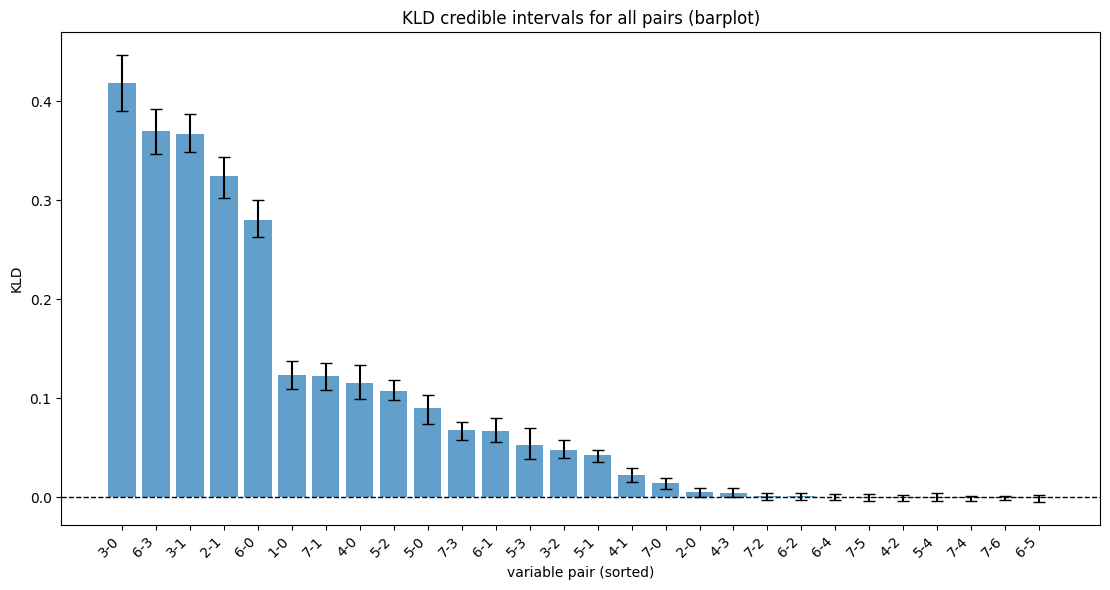

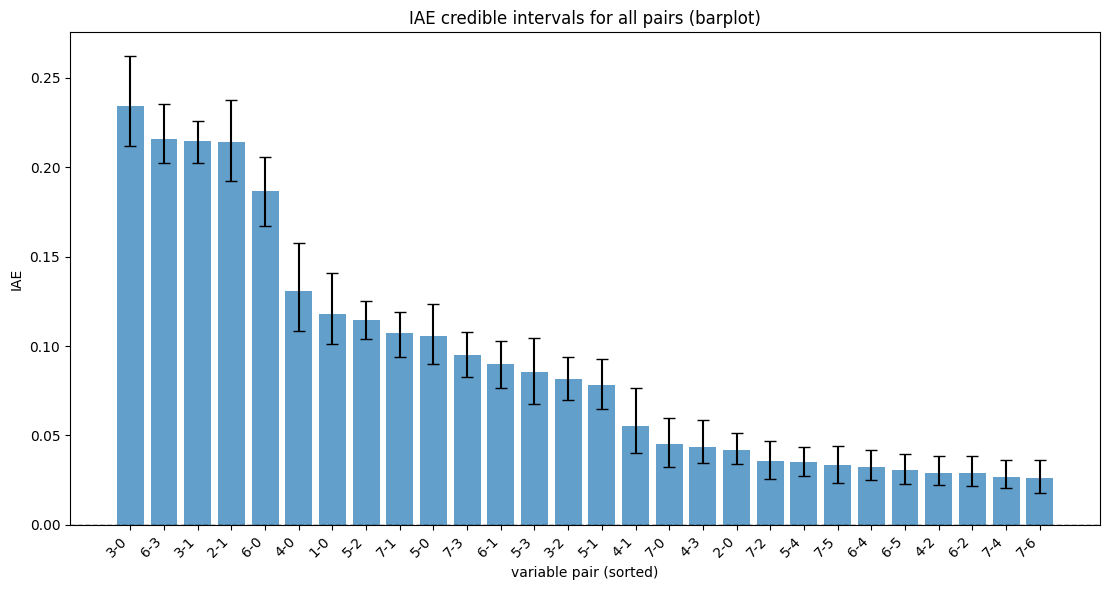

In [26]:
plot_metric_bar_ci(df_ci, metric="kld", log_scale=False)
plot_metric_bar_ci(df_ci, metric="iae", log_scale=False)


In [27]:
#CI_groups = theta_ci_by_group(VI, level=0.95, sort_within_group=True)

#if CI_groups["transformation"] is not None:
#    plot_theta_ci_group(CI_groups["transformation"], "Transformation", max_params=200)

#if CI_groups["decorrelation"] is not None:
#    plot_theta_ci_group(CI_groups["decorrelation"], "Decorrelation", max_params=200)


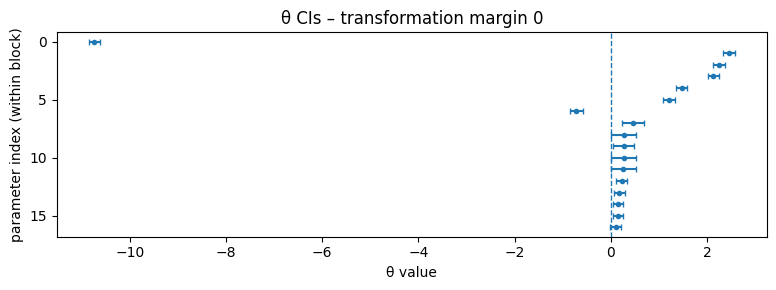

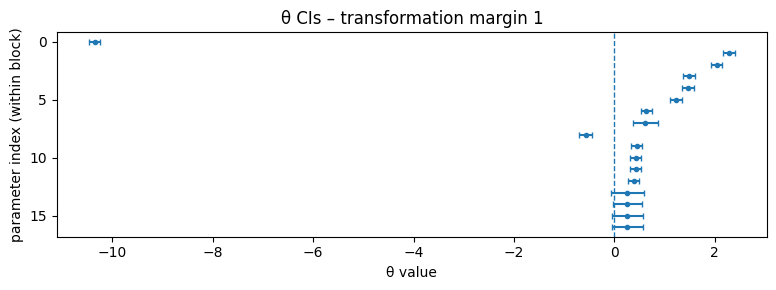

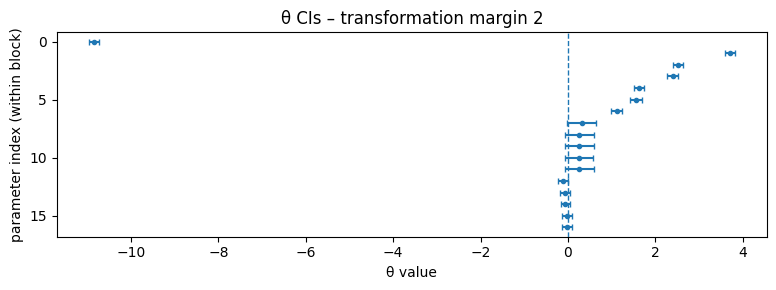

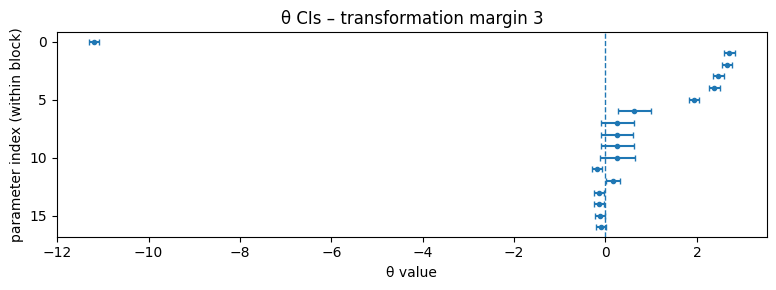

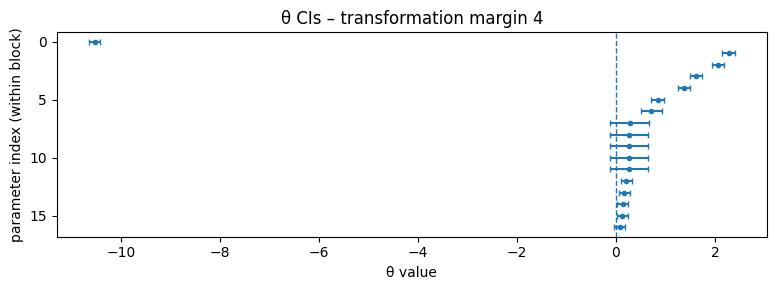

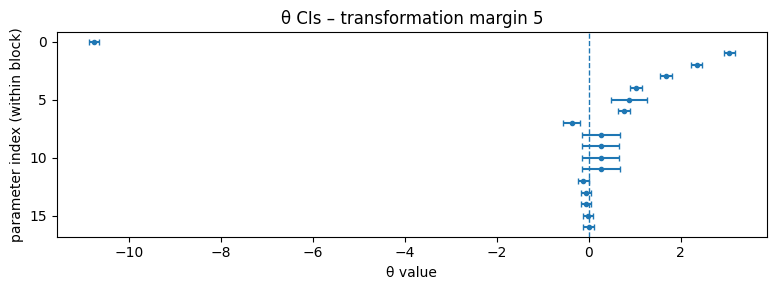

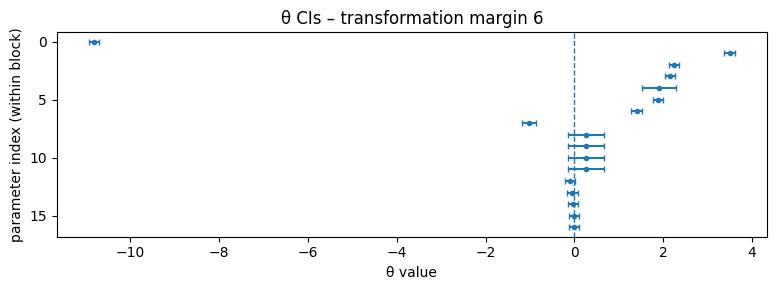

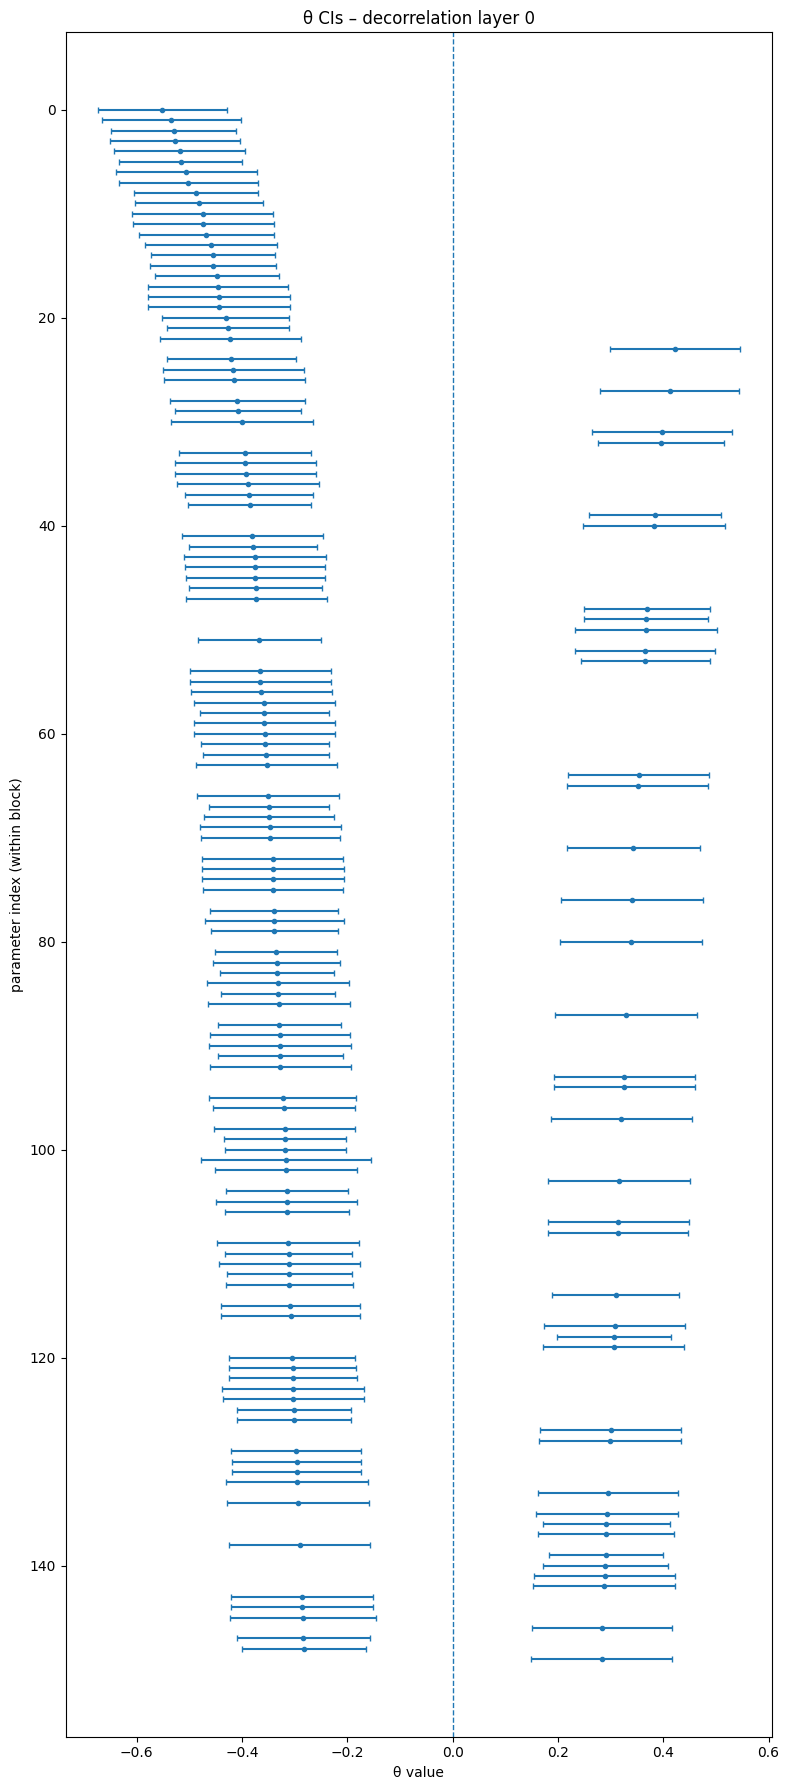

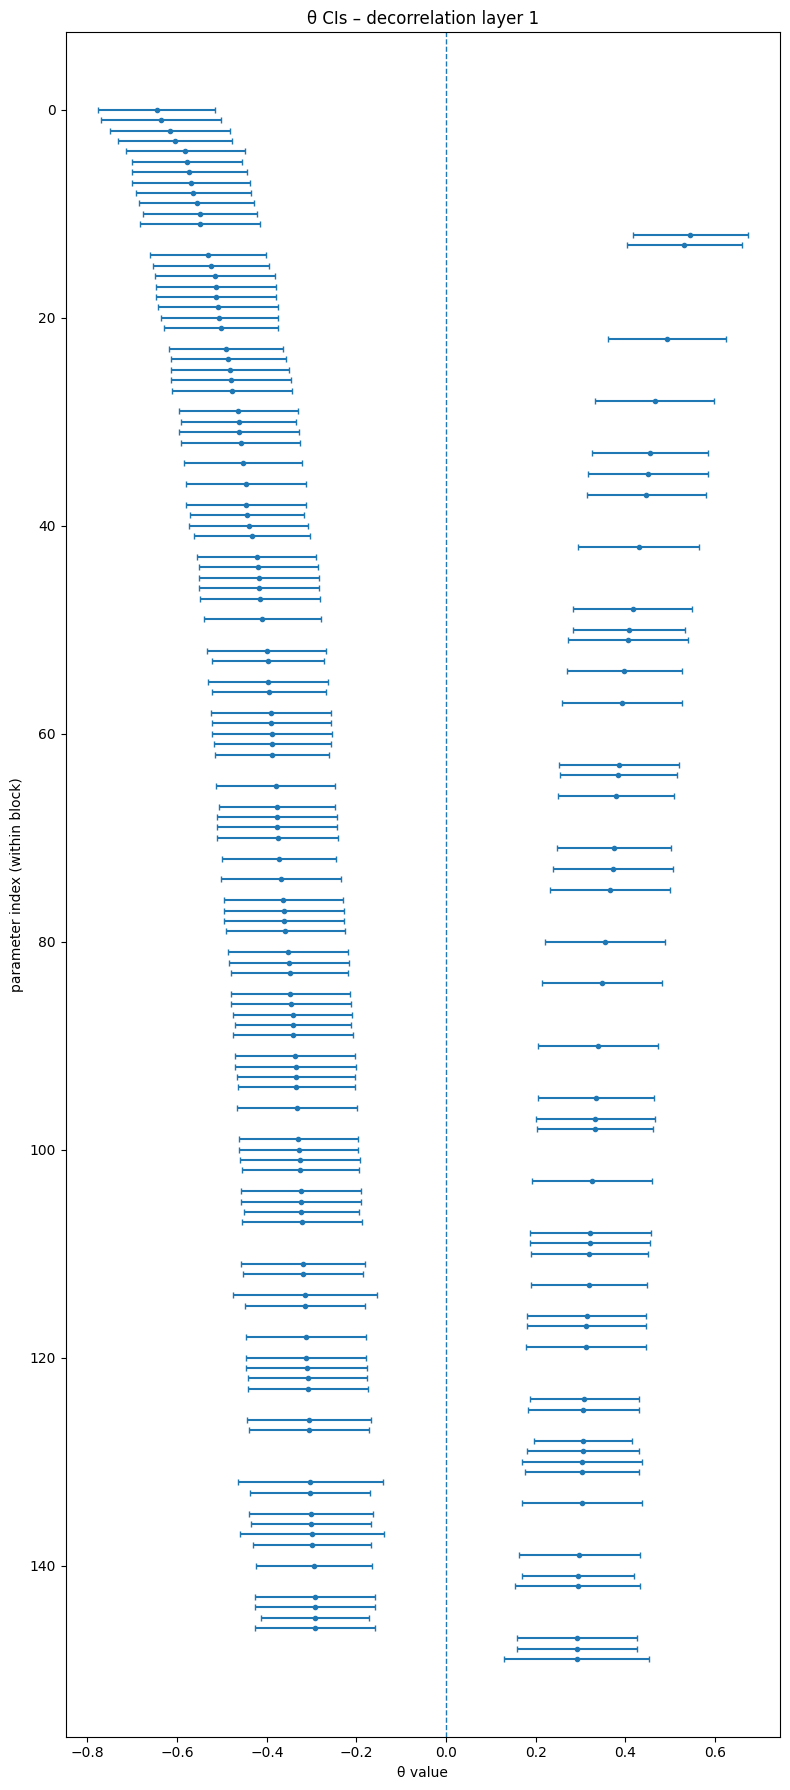

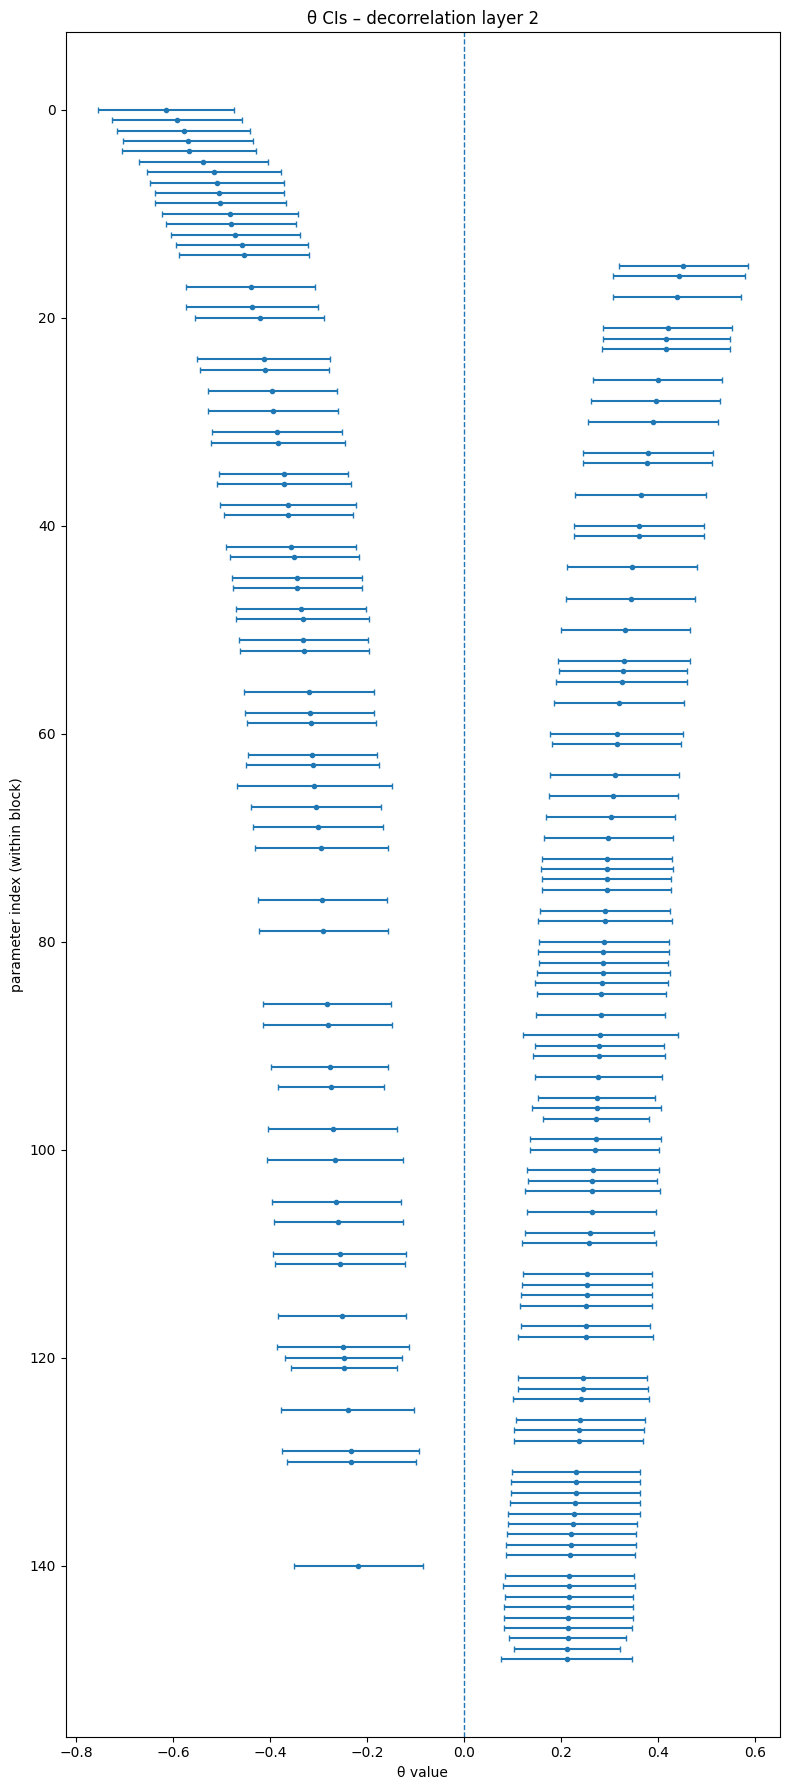

In [28]:
ci_blocks = theta_ci_by_schema(VI, level=0.95, sort_within_group=True)

# Transformation per margin
for j in range(7):
    key = f"transformation.params.{j}"
    plot_theta_ci_block(ci_blocks[key], title=f"θ CIs – transformation margin {j}", max_params=150)

# Decorrelation layers
for ℓ in range(3):
    key = f"decorrelation_layers.{ℓ}.params"
    plot_theta_ci_block(ci_blocks[key], title=f"θ CIs – decorrelation layer {ℓ}", max_params=150)


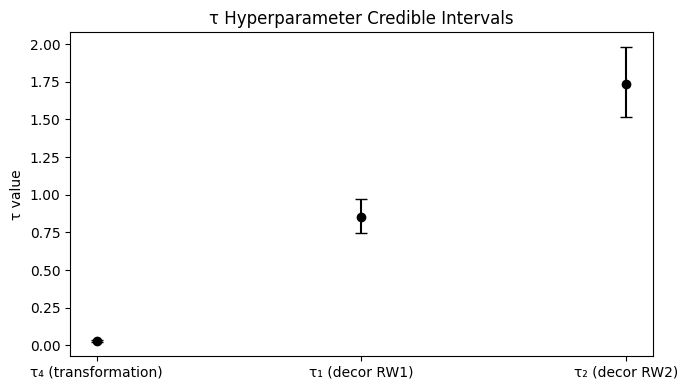

In [29]:
ci_4 = tau_ci_from_node(tau_nodes.node4)
ci_2 = tau_ci_from_node(tau_nodes.node2)
ci_1 = tau_ci_from_node(tau_nodes.node1)

tau_info = [
    ("τ₄ (transformation)", ci_4["mean"], ci_4["lower"], ci_4["upper"]),
]
if True: ### decor_present output from train method
    tau_info += [
        ("τ₁ (decor RW1)", ci_1["mean"], ci_1["lower"], ci_1["upper"]),
        ("τ₂ (decor RW2)", ci_2["mean"], ci_2["lower"], ci_2["upper"]),
    ]
plot_tau_nodes(tau_info)

we plot synthetic samples and overlay the conditional dependence structure for all pairs with strong conditional dependence according to there IAE metric.

In [30]:
synthetic_samples = model.sample(2000)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1299: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


[FIX] var 0: valid interval = [-9.999999, 9.999999]
[FIX] var 1: valid interval = [-9.999999, 9.999999]
[FIX] var 2: valid interval = [-9.999999, 9.999999]
[FIX] var 3: valid interval = [-9.999999, 9.999999]
[FIX] var 4: valid interval = [-9.999999, 9.999999]
[FIX] var 5: valid interval = [-9.999999, 9.999999]
[FIX] var 6: valid interval = [-9.999999, 9.999999]
[FIX] var 7: valid interval = [-9.999999, 9.999999]


/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


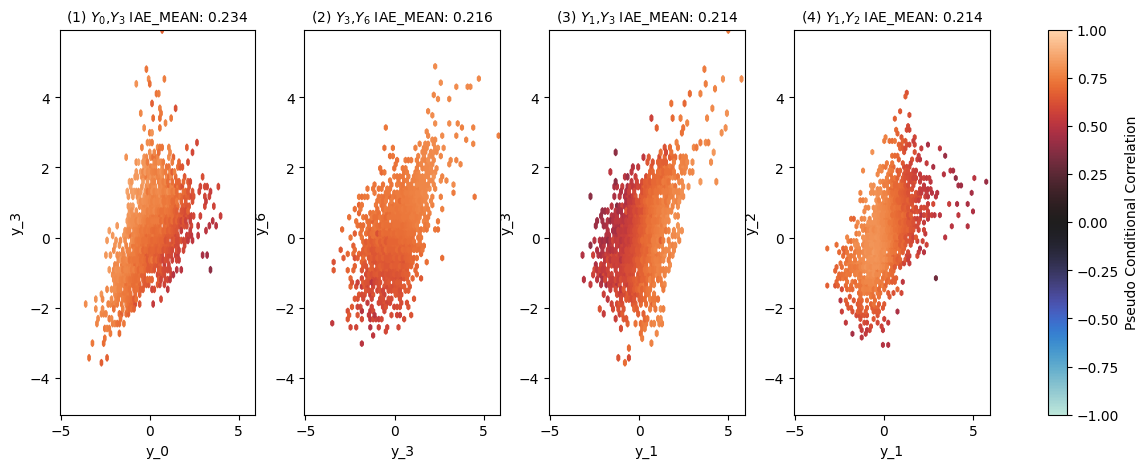

In [31]:
model.plot_conditional_dependence_structure(data=synthetic_samples,
                          dependence_metric_threshholding="iae_mean",
                          minimum_dependence_threshold=0.2, 
                          )

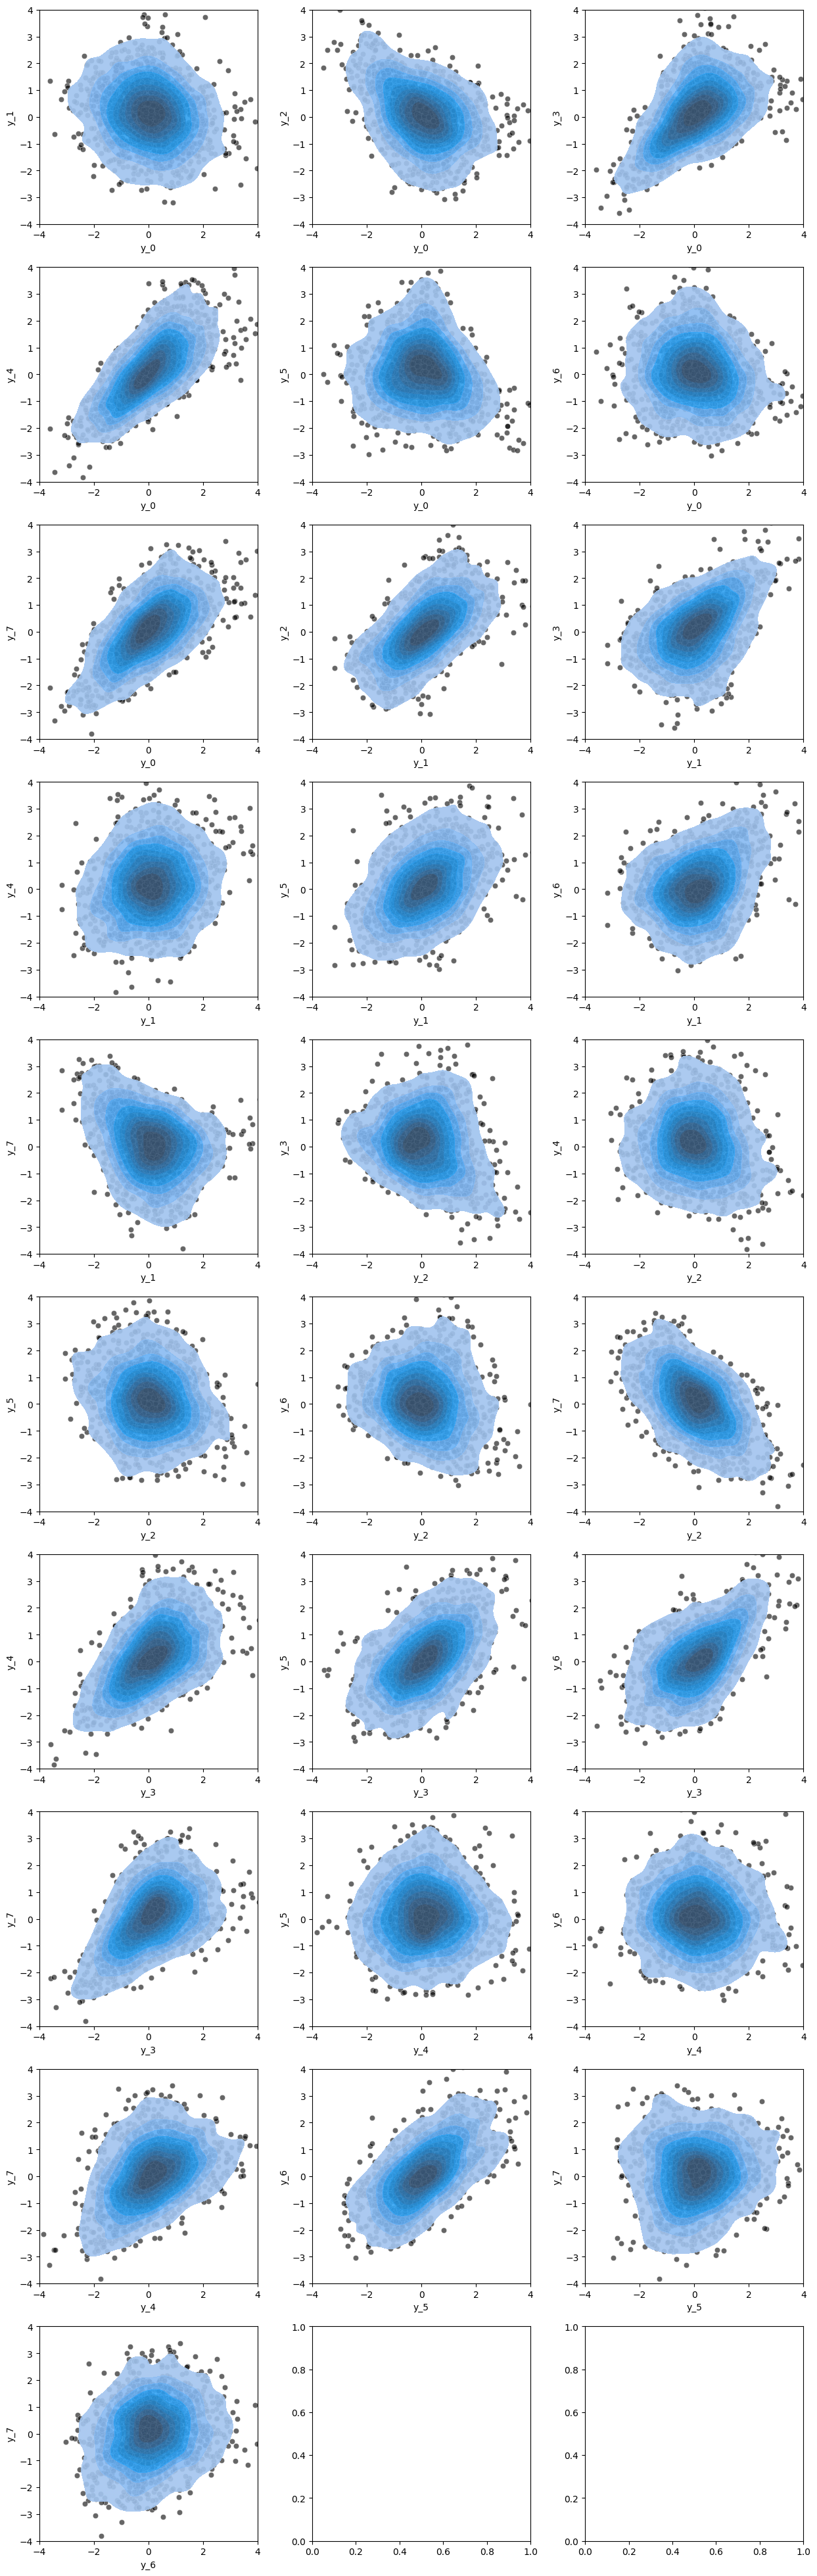

In [32]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The splines of the model, 10 transformation layer splines and 3 x 45 decorrelation layer splines can also be plotted.

In [33]:
#model.plot_splines(layer_type="transformation")

In [34]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

In [35]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

In [36]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)

### 6. Identifying the Conditional Independence Graph

We compare the true known conditional independence Graph to the one learned by the GTM. To do so we first merge the true structure table with our learned one.

In [37]:
merged_ci_tables = pd.merge(
    conditional_independence_table,
    df_true_structure_sub,
    on=["var_row", "var_col"]
)


take a look at the table and sort by some idicator such as iae.

In [38]:
#merged_ci_tables.sort_values("iae",ascending=False) 

with the spearman and pearson correlations one can see how similar the metrics are and how strongly correlated they are to the dependence.

In [39]:
merged_ci_tables.corr("spearman") #"pearson"

,index,var_row,var_col,abs_mean,mean,std,min,q_1,q_5,q_10,...,cond_correlation_abs_lo,cond_correlation_abs_hi,cond_correlation_square_mean,kld_mean,kld_lo,kld_hi,iae_mean,iae_lo,iae_hi,dependence
index,1.000000,0.982607,0.619978,-0.508484,0.093049,-0.488232,0.185550,0.169130,0.151067,0.114943,...,-0.474548,-0.436782,-0.440613,-0.489874,-0.457033,-0.500274,-0.497537,-0.521620,-0.509031,-0.385640
var_row,0.982607,1.000000,0.470238,-0.421953,0.111685,-0.408584,0.202760,0.183543,0.163489,0.123104,...,-0.390481,-0.355387,-0.353159,-0.395215,-0.373213,-0.409420,-0.413876,-0.443677,-0.427245,-0.360888
var_col,0.619978,0.470238,1.000000,-0.638082,-0.060438,-0.628055,-0.004178,0.000000,0.003064,0.003621,...,-0.587392,-0.553134,-0.587671,-0.646995,-0.604103,-0.633904,-0.606888,-0.590456,-0.609116,-0.293221
abs_mean,-0.508484,-0.421953,-0.638082,1.000000,-0.234264,0.864806,-0.288451,-0.289546,-0.282978,-0.268747,...,0.951286,0.948550,0.958949,0.960044,0.933771,0.975369,0.971538,0.958949,0.968254,0.722520
mean,0.093049,0.111685,-0.060438,-0.234264,1.000000,-0.084291,0.951286,0.948550,0.961686,0.973727,...,-0.212917,-0.230980,-0.235906,-0.180624,-0.145047,-0.177340,-0.214559,-0.191024,-0.226054,-0.261526
std,-0.488232,-0.408584,-0.628055,0.864806,-0.084291,1.000000,-0.200876,-0.223317,-0.203065,-0.175151,...,0.823755,0.783251,0.804598,0.863711,0.874658,0.867542,0.847838,0.849480,0.834154,0.802308
min,0.185550,0.202760,-0.004178,-0.288451,0.951286,-0.200876,1.000000,0.991242,0.978654,0.961686,...,-0.266557,-0.272031,-0.279146,-0.240832,-0.200328,-0.246853,-0.281883,-0.263273,-0.288998,-0.367909
q_1,0.169130,0.183543,0.000000,-0.289546,0.948550,-0.223317,0.991242,1.000000,0.992885,0.977559,...,-0.258894,-0.256705,-0.269294,-0.239190,-0.201970,-0.246853,-0.277504,-0.261084,-0.282978,-0.376774
q_5,0.151067,0.163489,0.003064,-0.282978,0.961686,-0.203065,0.978654,0.992885,1.000000,0.993432,...,-0.253968,-0.247947,-0.267652,-0.232622,-0.193760,-0.238095,-0.270389,-0.253421,-0.276409,-0.332448
q_10,0.114943,0.123104,0.003621,-0.268747,0.973727,-0.175151,0.961686,0.977559,0.993432,1.000000,...,-0.241927,-0.237001,-0.259989,-0.216749,-0.178435,-0.217296,-0.250684,-0.231527,-0.257800,-0.288122


however the proper metric as identifying full conditional independence is a classification task is the AUC (Area under the ROC-Curve).

In [40]:
auc_iae = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
auc_kld = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
auc_corr = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
auc_pmat = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
print("AUC IAE                    :",auc_iae)
print("AUC KLD                    :",auc_kld)
print("AUC Conditional Correlation:",auc_corr)
print("AUC Precision Matrix       :",auc_pmat)

AUC IAE                    : 0.9128205128205129
AUC KLD                    : 0.9128205128205128
AUC Conditional Correlation: 0.8923076923076924
AUC Precision Matrix       : 0.9230769230769231


We further print the ROC Curves for different metrics.

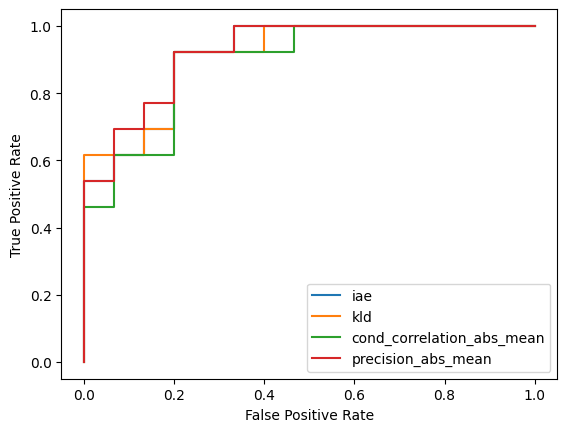

In [41]:
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
plt.plot(fpr, tpr, label="iae")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
plt.plot(fpr, tpr, label="kld")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
plt.plot(fpr, tpr, label="cond_correlation_abs_mean")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
plt.plot(fpr, tpr, label="precision_abs_mean")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()